In [1]:
import torch
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

### Imports

In [2]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

### Variables

In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40

LEARNING_RATE = 1e-4
NUM_CLASSES = 10
IMG_SIZE = 28 # RESIZING
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
PATCH_SIZE = 4
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0)
print(device_name)
print(device)

NVIDIA GeForce GTX 1070
cuda


### NOTES:

Learning Rate: Imagine you're learning to ride a bike. The learning rate is like how much you adjust your balance based on how wobbly or steady you feel. If you adjust it too much, you might fall off!

Number of Classes: This is like how many different types of ice cream flavors you can choose from at an ice cream shop. If there are 8 classes, it means you can pick from 8 different flavors (like chocolate, vanilla, strawberry, etc.).

Patch Size: Think of a patch like a small piece of a puzzle. If the patch size is 4, it means the picture is divided into small 4x4 pieces to make it easier to work with.

Image Size: This is how big the whole picture is. If the image size is 28, it means the picture is 28 pixels wide and 28 pixels tall, like a small square picture.

Input Channels: This tells us how many colors are in the picture. If it's 1 channel, it's like a black-and-white picture. If it's 3 channels, it's like a colorful picture.

Number of Heads: Imagine having 8 friends who can help you look at different parts of a picture at the same time. Each friend (or head) focuses on a different part to understand it better.

Dropout: Sometimes, when you're learning something new, you might forget a little bit to remember more important things. Dropout is like this—it helps the computer forget some things to focus better on what's important.

Hidden Dimension: This is like how big the computer's brain is while it's thinking about the picture. A bigger brain can think about more details and understand things better.

Adam Weight Decay: This is a way to keep the computer from getting too obsessed with small details. It helps the computer balance learning new things without focusing too much on tiny changes.

Adam Betas: These are special settings that help the computer learn faster and smoother, like giving it a good pair of glasses to see clearer.

Activation: This is like how excited the computer gets when it finds something interesting in the picture. "Gelu" is one way the computer gets excited—it's a fun way to help it learn more effectively.

Number of Encoders: Think of this like layers of a cake. Each layer (or encoder) helps the computer understand the picture better by looking at it in different ways.

Embed Dimension: This is how the computer breaks the picture into small pieces to understand each part better. It's like cutting a big cake into smaller, easier-to-eat slices.

Number of Patches: This tells us how many small pieces the computer makes from the picture. It's like cutting a big puzzle into smaller pieces to solve it step by step.

### Patch Embedding

In [4]:
import torch
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()  # Initialize the PatchEmbedding class
        
        # Define a sequence of steps to process the image patches
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,   # Number of colors in the image
                out_channels=embed_dim,   # How much we want to know about each piece
                kernel_size=patch_size,   # The size of the piece
                stride=patch_size         # How far apart we're looking at pieces
            ),
            nn.Flatten(2)  # Flatten the image pieces into a line
        )

        # Create a special marker for the entire picture
        self.cls_token =  nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        
        # Create markers for where each piece of the picture is
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        
        # Prepare to ignore some unimportant details to focus better
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
            # Move input to the same device as the model
            x = x.to(device)
            
            # Apply patching and reshape
            # Make the picture smaller and put it in order
            x = self.patcher(x).permute(0, 2, 1)
            
            # Add a special marker for the whole picture
            cls_token = self.cls_token.expand(x.shape[0], -1, -1)
            
            # Put the marker together with the picture pieces
            x = torch.cat([cls_token, x], dim=1)

            x = self.position_embeddings + x

            # Sometimes ignore a few unimportant details to focus better
            x = self.dropout(x)

            
            return x


model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


### Vit Implementation

In [5]:
class Vit(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim,
                 dropout,activation, in_channels):
        super().__init__()
        
        self.embeddings_block = PatchEmbedding(embed_dim, 
                                              patch_size, 
                                              num_patches, 
                                              dropout, 
                                              in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, 
                                                   nhead=num_heads, 
                                                   dropout=dropout, 
                                                   activation=activation, 
                                                   batch_first=True, 
                                                   norm_first=True)
        
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, 
                                                   num_layers=num_encoders)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])

        return x

model = Vit(NUM_PATCHES, 
            IMG_SIZE, 
            NUM_CLASSES, 
            PATCH_SIZE, 
            EMBED_DIM, 
            NUM_ENCODERS, 
            NUM_HEADS, 
            HIDDEN_DIM, 
            DROPOUT,
            ACTIVATION, 
            IN_CHANNELS).to(device)

x = torch.randn(512, 1 ,28, 28).to(device)
print(model(x).shape)

torch.Size([512, 10])


D:\SnapfoliaV2\.env\snapv2\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
D:\SnapfoliaV2\.env\snapv2\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


### Dataset Prep

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [10]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}

In [11]:
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}

In [12]:
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

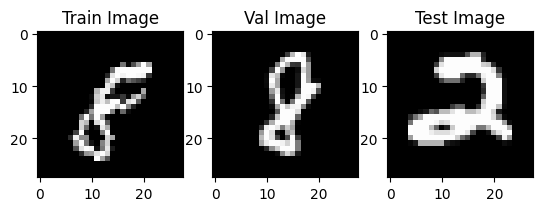

In [13]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [14]:
train_dataloader = DataLoader(dataset=train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.63it/s]


------------------------------
Train Loss EPOCH 1: 2.2578
Valid Loss EPOCH 1: 2.0940


  2%|██                                                                                 | 1/40 [00:22<14:20, 22.05s/it]

Train Accuracy EPOCH 1: 0.1612
Valid Accuracy EPOCH 1: 0.2467
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.07it/s]


------------------------------
Train Loss EPOCH 2: 2.0183
Valid Loss EPOCH 2: 1.8309


  5%|████▏                                                                              | 2/40 [00:43<13:50, 21.87s/it]

Train Accuracy EPOCH 2: 0.2644
Valid Accuracy EPOCH 2: 0.3567
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.90it/s]


------------------------------
Train Loss EPOCH 3: 1.7203
Valid Loss EPOCH 3: 1.5300


  8%|██████▏                                                                            | 3/40 [01:05<13:30, 21.90s/it]

Train Accuracy EPOCH 3: 0.4098
Valid Accuracy EPOCH 3: 0.4967
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.12it/s]


------------------------------
Train Loss EPOCH 4: 1.5322
Valid Loss EPOCH 4: 1.4076


 10%|████████▎                                                                          | 4/40 [01:27<13:05, 21.82s/it]

Train Accuracy EPOCH 4: 0.4935
Valid Accuracy EPOCH 4: 0.5510
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.15it/s]


------------------------------
Train Loss EPOCH 5: 1.4041
Valid Loss EPOCH 5: 1.2717


 12%|██████████▍                                                                        | 5/40 [01:49<12:41, 21.75s/it]

Train Accuracy EPOCH 5: 0.5516
Valid Accuracy EPOCH 5: 0.6205
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.24it/s]


------------------------------
Train Loss EPOCH 6: 1.2887
Valid Loss EPOCH 6: 1.1282


 15%|████████████▍                                                                      | 6/40 [02:10<12:16, 21.65s/it]

Train Accuracy EPOCH 6: 0.6093
Valid Accuracy EPOCH 6: 0.6852
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.17it/s]


------------------------------
Train Loss EPOCH 7: 1.1726
Valid Loss EPOCH 7: 1.0479


 18%|██████████████▌                                                                    | 7/40 [02:32<11:52, 21.61s/it]

Train Accuracy EPOCH 7: 0.6667
Valid Accuracy EPOCH 7: 0.7307
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.22it/s]


------------------------------
Train Loss EPOCH 8: 1.0581
Valid Loss EPOCH 8: 0.9378


 20%|████████████████▌                                                                  | 8/40 [02:53<11:30, 21.57s/it]

Train Accuracy EPOCH 8: 0.7164
Valid Accuracy EPOCH 8: 0.7638
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.38it/s]


------------------------------
Train Loss EPOCH 9: 0.9709
Valid Loss EPOCH 9: 0.8482


 22%|██████████████████▋                                                                | 9/40 [03:14<11:07, 21.54s/it]

Train Accuracy EPOCH 9: 0.7439
Valid Accuracy EPOCH 9: 0.7905
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.18it/s]


------------------------------
Train Loss EPOCH 10: 0.9042
Valid Loss EPOCH 10: 0.7963


 25%|████████████████████▌                                                             | 10/40 [03:36<10:46, 21.54s/it]

Train Accuracy EPOCH 10: 0.7598
Valid Accuracy EPOCH 10: 0.8002
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.30it/s]


------------------------------
Train Loss EPOCH 11: 0.8450
Valid Loss EPOCH 11: 0.7347


 28%|██████████████████████▌                                                           | 11/40 [03:58<10:24, 21.53s/it]

Train Accuracy EPOCH 11: 0.7732
Valid Accuracy EPOCH 11: 0.8214
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.21it/s]


------------------------------
Train Loss EPOCH 12: 0.8018
Valid Loss EPOCH 12: 0.7013


 30%|████████████████████████▌                                                         | 12/40 [04:19<10:02, 21.51s/it]

Train Accuracy EPOCH 12: 0.7861
Valid Accuracy EPOCH 12: 0.8302
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.33it/s]


------------------------------
Train Loss EPOCH 13: 0.7519
Valid Loss EPOCH 13: 0.6848


 32%|██████████████████████████▋                                                       | 13/40 [04:41<09:40, 21.51s/it]

Train Accuracy EPOCH 13: 0.8010
Valid Accuracy EPOCH 13: 0.8326
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.20it/s]


------------------------------
Train Loss EPOCH 14: 0.7253
Valid Loss EPOCH 14: 0.6478


 35%|████████████████████████████▋                                                     | 14/40 [05:02<09:19, 21.50s/it]

Train Accuracy EPOCH 14: 0.8067
Valid Accuracy EPOCH 14: 0.8305
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.33it/s]


------------------------------
Train Loss EPOCH 15: 0.6747
Valid Loss EPOCH 15: 0.5836


 38%|██████████████████████████████▊                                                   | 15/40 [05:23<08:57, 21.49s/it]

Train Accuracy EPOCH 15: 0.8242
Valid Accuracy EPOCH 15: 0.8576
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.29it/s]


------------------------------
Train Loss EPOCH 16: 0.6453
Valid Loss EPOCH 16: 0.5567


 40%|████████████████████████████████▊                                                 | 16/40 [05:45<08:36, 21.50s/it]

Train Accuracy EPOCH 16: 0.8315
Valid Accuracy EPOCH 16: 0.8700
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.36it/s]


------------------------------
Train Loss EPOCH 17: 0.6150
Valid Loss EPOCH 17: 0.5334


 42%|██████████████████████████████████▊                                               | 17/40 [06:07<08:14, 21.52s/it]

Train Accuracy EPOCH 17: 0.8404
Valid Accuracy EPOCH 17: 0.8776
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.18it/s]


------------------------------
Train Loss EPOCH 18: 0.5820
Valid Loss EPOCH 18: 0.5106


 45%|████████████████████████████████████▉                                             | 18/40 [06:28<07:53, 21.51s/it]

Train Accuracy EPOCH 18: 0.8485
Valid Accuracy EPOCH 18: 0.8750
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.28it/s]


------------------------------
Train Loss EPOCH 19: 0.5541
Valid Loss EPOCH 19: 0.4826


 48%|██████████████████████████████████████▉                                           | 19/40 [06:50<07:32, 21.54s/it]

Train Accuracy EPOCH 19: 0.8575
Valid Accuracy EPOCH 19: 0.8950
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.25it/s]


------------------------------
Train Loss EPOCH 20: 0.5238
Valid Loss EPOCH 20: 0.4484


 50%|█████████████████████████████████████████                                         | 20/40 [07:11<07:10, 21.52s/it]

Train Accuracy EPOCH 20: 0.8669
Valid Accuracy EPOCH 20: 0.8950
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.40it/s]


------------------------------
Train Loss EPOCH 21: 0.5003
Valid Loss EPOCH 21: 0.4513


 52%|███████████████████████████████████████████                                       | 21/40 [07:32<06:47, 21.47s/it]

Train Accuracy EPOCH 21: 0.8707
Valid Accuracy EPOCH 21: 0.8890
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.24it/s]


------------------------------
Train Loss EPOCH 22: 0.4936
Valid Loss EPOCH 22: 0.4082


 55%|█████████████████████████████████████████████                                     | 22/40 [07:54<06:26, 21.45s/it]

Train Accuracy EPOCH 22: 0.8711
Valid Accuracy EPOCH 22: 0.9005
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.30it/s]


------------------------------
Train Loss EPOCH 23: 0.4633
Valid Loss EPOCH 23: 0.4069


 57%|███████████████████████████████████████████████▏                                  | 23/40 [08:15<06:04, 21.44s/it]

Train Accuracy EPOCH 23: 0.8796
Valid Accuracy EPOCH 23: 0.9069
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.25it/s]


------------------------------
Train Loss EPOCH 24: 0.4490
Valid Loss EPOCH 24: 0.3883


 60%|█████████████████████████████████████████████████▏                                | 24/40 [08:37<05:43, 21.44s/it]

Train Accuracy EPOCH 24: 0.8818
Valid Accuracy EPOCH 24: 0.9064
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.32it/s]


------------------------------
Train Loss EPOCH 25: 0.4253
Valid Loss EPOCH 25: 0.3681


 62%|███████████████████████████████████████████████████▎                              | 25/40 [08:58<05:21, 21.44s/it]

Train Accuracy EPOCH 25: 0.8895
Valid Accuracy EPOCH 25: 0.9095
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.27it/s]


------------------------------
Train Loss EPOCH 26: 0.4132
Valid Loss EPOCH 26: 0.3560


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [09:20<05:00, 21.45s/it]

Train Accuracy EPOCH 26: 0.8907
Valid Accuracy EPOCH 26: 0.9138
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.23it/s]


------------------------------
Train Loss EPOCH 27: 0.3966
Valid Loss EPOCH 27: 0.3340


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [09:41<04:38, 21.45s/it]

Train Accuracy EPOCH 27: 0.8943
Valid Accuracy EPOCH 27: 0.9193
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.15it/s]


------------------------------
Train Loss EPOCH 28: 0.3875
Valid Loss EPOCH 28: 0.3237


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [10:03<04:18, 21.56s/it]

Train Accuracy EPOCH 28: 0.8955
Valid Accuracy EPOCH 28: 0.9200
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.21it/s]


------------------------------
Train Loss EPOCH 29: 0.3725
Valid Loss EPOCH 29: 0.3262


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [10:24<03:56, 21.52s/it]

Train Accuracy EPOCH 29: 0.9003
Valid Accuracy EPOCH 29: 0.9160
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.20it/s]


------------------------------
Train Loss EPOCH 30: 0.3664
Valid Loss EPOCH 30: 0.3137


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [10:46<03:34, 21.49s/it]

Train Accuracy EPOCH 30: 0.9006
Valid Accuracy EPOCH 30: 0.9202
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.28it/s]


------------------------------
Train Loss EPOCH 31: 0.3557
Valid Loss EPOCH 31: 0.2986


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [11:07<03:13, 21.46s/it]

Train Accuracy EPOCH 31: 0.9027
Valid Accuracy EPOCH 31: 0.9252
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.28it/s]


------------------------------
Train Loss EPOCH 32: 0.3404
Valid Loss EPOCH 32: 0.2866


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [11:29<02:51, 21.45s/it]

Train Accuracy EPOCH 32: 0.9074
Valid Accuracy EPOCH 32: 0.9243
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.24it/s]


------------------------------
Train Loss EPOCH 33: 0.3370
Valid Loss EPOCH 33: 0.2891


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [11:50<02:30, 21.45s/it]

Train Accuracy EPOCH 33: 0.9071
Valid Accuracy EPOCH 33: 0.9300
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.25it/s]


------------------------------
Train Loss EPOCH 34: 0.3206
Valid Loss EPOCH 34: 0.2747


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [12:11<02:08, 21.45s/it]

Train Accuracy EPOCH 34: 0.9111
Valid Accuracy EPOCH 34: 0.9314
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.29it/s]


------------------------------
Train Loss EPOCH 35: 0.3179
Valid Loss EPOCH 35: 0.2730


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [12:33<01:47, 21.43s/it]

Train Accuracy EPOCH 35: 0.9125
Valid Accuracy EPOCH 35: 0.9267
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.28it/s]


------------------------------
Train Loss EPOCH 36: 0.3025
Valid Loss EPOCH 36: 0.2613


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [12:54<01:25, 21.41s/it]

Train Accuracy EPOCH 36: 0.9175
Valid Accuracy EPOCH 36: 0.9345
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.32it/s]


------------------------------
Train Loss EPOCH 37: 0.2961
Valid Loss EPOCH 37: 0.2582


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [13:16<01:04, 21.41s/it]

Train Accuracy EPOCH 37: 0.9171
Valid Accuracy EPOCH 37: 0.9360
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.24it/s]


------------------------------
Train Loss EPOCH 38: 0.2868
Valid Loss EPOCH 38: 0.2410


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [13:37<00:42, 21.42s/it]

Train Accuracy EPOCH 38: 0.9201
Valid Accuracy EPOCH 38: 0.9345
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.22it/s]


------------------------------
Train Loss EPOCH 39: 0.2865
Valid Loss EPOCH 39: 0.2556


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [13:58<00:21, 21.39s/it]

Train Accuracy EPOCH 39: 0.9201
Valid Accuracy EPOCH 39: 0.9300
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.25it/s]


------------------------------
Train Loss EPOCH 40: 0.2822
Valid Loss EPOCH 40: 0.2465


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:20<00:00, 21.51s/it]

Train Accuracy EPOCH 40: 0.9200
Valid Accuracy EPOCH 40: 0.9367
------------------------------
Training Time: 860.33s


In [17]:
torch.cuda.empty_cache()

### Prediction

In [22]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:06<00:00,  8.21it/s]


<Figure size 640x480 with 0 Axes>

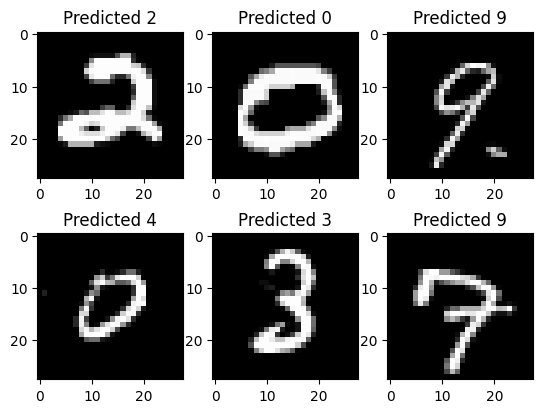

In [23]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1